In [1]:
# import os
# os.environ["XLA_FLAGS"] = "--xla_gpu_strict_conv_algorithm_picker=false"

# import jax
import jax
jax.config.update('jax_platform_name', 'cpu')
# print("jax version:", jax.__version__)
# print("jax devices:", jax.devices())
import jax.numpy as jnp
import numpy as np
import functools
import abc
import torch
import torch.nn as nn
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False
import cvxpy as cp

from IPython.display import HTML
import matplotlib.animation as anim
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import time
import pypalettes

import hj_reachability as hj
from hj_reachability.finite_differences import upwind_first

from hjnnv import hjnnvUncertaintyAwareFilter
from dynamic_models.beacon import BeaconDynamics
from simulators.beacon_env.desired_trajectories import DesiredTrajectory


# jax.config.update("jax_cudnn_use_autotuned", False)
import warnings
warnings.filterwarnings("ignore", category=ResourceWarning)
warnings.filterwarnings("ignore", category=PendingDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)


/home/nick/code/hjnnv/src/third_party/jax_verify/jax_verify/src/synthetic_primitives.py:40: DeprecationWarning: jax.custom_derivatives.custom_jvp_call_jaxpr_p is deprecated, use jax.extend.core.primitives.custom_jvp_call_p instead.
  jax.custom_derivatives.custom_jvp_call_jaxpr_p,


In [2]:
import jax.numpy as jnp
import jax
import numpy as np

import hj_reachability as hj
import torch

from dynamic_models.dynamics import HJNNVDynamics
from learned_models.beacon.estimators import MLP, CNN

from utils.mlp2jax import torch_mlp2jax
from utils.torch2jaxmodel import torch_to_jax_model


class Integrator(HJNNVDynamics):
    def __init__(self,
                 dt=0.01,
                 max_input=1.0,
                 max_disturbance=0.01,
                 obs_disturbance=0.02,
                 control_mode="max",
                 disturbance_mode="min",
                 control_space=None,
                 disturbance_space=None,
                 model_name=None,
                 random_seed=0
                 ):

        if control_space is None:
            control_space = hj.sets.Box(jnp.array([-max_input,]),
                                        jnp.array([max_input,]))
        if disturbance_space is None:
            disturbance_space = hj.sets.Box(jnp.array([-max_disturbance]),
                                            jnp.array([max_disturbance,]))

        if model_name is not None:
            self.load_estimator(model_name=model_name)

        super().__init__(
            dt,
            control_mode,
            disturbance_mode,
            control_space,
            disturbance_space,
            random_seed
        )

    def open_loop_dynamics(self, state, time):
        xdot = 0.0
        return xdot

    def control_jacobian(self, state, time):
        return jnp.array(
            [1.0]
        )

    def disturbance_jacobian(self, state, time):
        return jnp.eye(1)

    def get_observation(self, state, time):
        # return state
        a = 4.0
        b = 4.0
        # return 1/(2 * b) * jnp.log(-(state/a + 1)/(state/a - 1))
        # return 1/b * jnp.sqrt(-2 * a / (state - a) - 1)
        # return state
        return -1 / b * jnp.log(a / (state + a - 1) - 1)


In [3]:
def integrator_controller(state, ref=0.95):
    return 1.0 * (ref - state)

dynamics = Integrator(
    dt=0.01,
    max_input=10.0,
    max_disturbance=0.001,
    obs_disturbance=0.001,
    model_name=None
)

def simulate_trajectory(dynamics, initial_state, control_policy, num_steps, use_observations=False):
    state = initial_state
    trajectory = [(state, dynamics.get_observation(state, time=0))]
    for t in range(num_steps):
        if use_observations:
            obs = dynamics.get_observation(state, time=t)
            state_hat = dynamics.get_state_estimate(obs)
        else:
            state_hat = state
        control = control_policy(state_hat)
        disturbance = dynamics.get_random_disturbance()
        state = dynamics.step(state, control, disturbance, time=t+1)
        observation = dynamics.get_observation(state, time=t+1)
        trajectory.append((state, observation))
    return trajectory


In [4]:
initial_state = jnp.array([1.3])
trajectory = simulate_trajectory(
    dynamics=dynamics,
    initial_state=initial_state,
    control_policy=integrator_controller,
    num_steps=5000,
)


(0.0, 10.0)

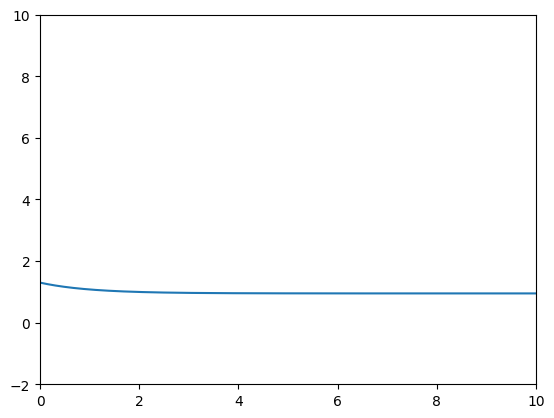

In [5]:
observations = jnp.array([obs for state, obs in trajectory])
states = jnp.array([state for state, obs in trajectory])
t = jnp.arange(len(states)) * dynamics.dt
plt.plot(t, states)
plt.ylim(-2, 10)
plt.xlim(0, 10)

In [5]:
epsilon = 0.1
dt = 0.01
max_input = 10.0
max_disturbance = 0.01
obs_disturbance = 0.0000001
seed = 0
dynamics = Integrator(
    dt=dt,
    max_input=max_input,
    max_disturbance=max_disturbance,
    obs_disturbance=obs_disturbance,
    model_name=None
)

grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(
            hj.sets.Box(
                np.array([-6.]),
                np.array([6.])),
            (50,),
        )
values = -jnp.power(grid.states[..., 0], 2) + 1.0

solver_settings = hj.SolverSettings.with_accuracy("very_high",
                                                  hamiltonian_postprocessor=hj.solver.backwards_reachable_tube)
cmap = 'viridis'

def estimation_function(observation):
    # return jnp.sqrt(observation)
    # a = 2.0
    # b = 5.0
    # return -2 * a / ((b * observation * observation) + 1) + a
    a = 4.0
    b = 4.0

    return a * jax.nn.sigmoid(b * observation) - (a - 1)

hjnnv_filter = hjnnvUncertaintyAwareFilter(
    dynamics=dynamics,
    pred_model=estimation_function,
    grid=grid,
    initial_values=values,
    num_controls=100,
    num_disturbances=2,
    time_horizon=10.0
)

100%|##########| 10.0000/10.0 [00:00<00:00, 131.38sim_s/s]


In [21]:
# grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(
#             hj.sets.Box(
#                 np.array([-3.0]),
#                 np.array([3.0])),
#             (1000,),
#         )
# values = -jnp.power(grid.states[..., 0], 2) + 1.0

# solver_settings = hj.SolverSettings.with_accuracy("very_high",
#                                                   hamiltonian_postprocessor=hj.solver.backwards_reachable_tube)

times = np.linspace(0, -10.0, 20)
initial_values = values
all_values = hj.solve(solver_settings, dynamics, grid, times, initial_values)

100%|##########| 10.0000/10.0 [00:00<00:00, 108.94sim_s/s]


In [8]:

vmin, vmax = all_values.min(), all_values.max()
levels = np.linspace(round(vmin), round(vmax), round(vmax) - round(vmin) + 1)
fig = plt.figure(figsize=(13, 8))


def render_frame(i, colorbar=False):
    plt.plot(grid.coordinate_vectors[0], all_values[i, :], color='blue')
    plt.plot(grid.coordinate_vectors[0], all_values[0, :], color='gray', linestyle='--')
    plt.plot(jnp.array([max_input, max_input]), jnp.array([-8.0, 1.5]), linestyle='--', color='red')
    plt.gca().grid(True)
    plt.ylim(-8, 1.5)



render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, all_values.shape[0], interval=500).to_html5_video())
plt.close(); animation


In [8]:
filter_type = "hjnnv_bestu"  # "none", "hj", "hjnnv_maxval", "hjnnv_bestu"
eps_multiplier = 1.0

state_history_hjnnv = []
state_hat_history_hjnnv = []
state_bounds_history_hjnnv = []
dynamics_state_bounds_history_hjnnv = []
ref_history_hjnnv = []

key = jax.random.PRNGKey(seed)
num_steps = 1500
dynamics.set_random_seed(seed)

# state_hat = state + epsilon * eps_multiplier
obs = dynamics.get_observation(jnp.array([0.0]), time=0)
state_hat = estimation_function(obs)
state_bounds = hjnnv_filter.nnv_state_bounds(
    obs=obs,
    eps=epsilon
)
dynamics_state_bounds = state_bounds  # Initialize dynamics_state_bounds
# print(state_bounds.lo)
state = jnp.array(state_bounds.lo)
u = integrator_controller(state_hat)
zero_counter = 0
ref = -0.95

for step in range(num_steps):
    key, subkey = jax.random.split(key)
    t = step * dynamics.dt
    # Simulate the system dynamics
    obs = dynamics.get_observation(state, time=step) + epsilon
    state_hat = estimation_function(obs)
    if step > 600:
        ref = 0.95
    u_nominal = integrator_controller(state_hat, ref=ref)
    # state_hat = state + epsilon * eps_multiplier
    
    time_start = time.time()
    if filter_type == "hjnnv_maxval" or filter_type == "hjnnv_bestu":
        # state_bounds = hj.sets.Box(state_hat - epsilon, state_hat + epsilon)
        print(f"Step {step}: Observation={obs}, State Hat={state_hat}, Obs^3={obs**3}, State={state}, State cbrt={jnp.cbrt(state)}")
        state_bounds = hjnnv_filter.nnv_state_bounds(
            obs=obs,
            eps=epsilon
        )
        state_eps = (state_bounds.hi - state_bounds.lo)/2.0
        # dynamics_state_bounds = hjnnv_filter.nnv_dynamics_state_bounds(
        #     state_hat,
        #     control=u,
        #     state_eps=state_eps,
        # )
        # state_bounds = hj.sets.Box(
        #     jnp.maximum(nn_state_bounds.lo, dynamics_state_bounds.lo),
        #     jnp.minimum(nn_state_bounds.hi, dynamics_state_bounds.hi)
        # )
        print(f"Step {step}: State Bounds: {state_bounds}")

        if filter_type == "hjnnv_maxval":
            v_star, u_star, worst_val, val_filter, min_vals, distances = hjnnv_filter.ua_filter_max_val(
                u_nominal,
                state_bounds,
                num_states=3,
                eps=1e-6
            )
        elif filter_type == "hjnnv_bestu":
            v_star, u_star, worst_val, val_filter, min_vals, distances, _, _, = hjnnv_filter.ua_filter_best_u(
                u_nominal,
                state_bounds,
                num_states=10,
                delta=0.01,
            )
    elif filter_type == "hj":

        lo = state - 1e-8
        hi = state + 1e-8
        state_bounds = hj.sets.Box(
            lo,
            hi
        )
        time_start = time.time()
        v_star, u_star, worst_val, val_filter, min_vals, distances = hjnnv_filter.ua_filter_max_val(
            u_nominal,
            state_bounds,
            num_states=2
        )
    elif filter_type == "none":
        u = u_nominal
        v_star = 0.0
        val_filter = 1.0  # positive value means no filtering
        lo = state - 1e-8
        hi = state + 1e-8
        state_bounds = hj.sets.Box(
            lo,
            hi
        )
    # if np.linalg.norm(state-1.0) < 1e-2:
    #     print(f"Step {step}: State near equilibrium, applying nominal control.")
    #     zero_counter += 1
    #     u = u_nominal
    # elif zero_counter < 100 and zero_counter > 0:
    #     print(f"Step {step}: In zero counter phase ({zero_counter}/100), applying nominal control.")
    #     zero_counter += 1
    #     u = u_nominal
    #     if zero_counter == 100:
    #         zero_counter = 0
    # else:
    print(f"Step {step}: {np.linalg.norm(state-1.0)}")
    if val_filter < 0.0:
        print(f"Step {step}: Using filtered control u_star={u_star}, state={state}, v_star={v_star}, val_filter={val_filter}")
        u = u_star
    else:
        u = u_nominal
    
    time_end = time.time()
    print(f"Step {step}: Filter execution time: {time_end - time_start:.5f} seconds")

    state_history_hjnnv.append(state)
    state_hat_history_hjnnv.append(state_hat)
    state_bounds_history_hjnnv.append(state_bounds)
    dynamics_state_bounds_history_hjnnv.append(dynamics_state_bounds)
    ref_history_hjnnv.append(ref)

    state = dynamics.step(state, u, dynamics.get_random_disturbance(), time=step)

Step 0: Observation=[0.27465302], State Hat=[0.], Obs^3=[0.02071825], State=[-0.32848006], State cbrt=[-0.68997973]
Step 0: State Bounds: Box(lo=Array([-0.32847995], dtype=float32), hi=Array([0.29999995], dtype=float32))
Step 0: 1.3284800052642822
Step 0: Filter execution time: 0.00135 seconds
Step 1: Observation=[0.27195343], State Hat=[-0.00812078], Obs^3=[0.02011332], State=[-0.33807862], State cbrt=[-0.69663596]
Step 1: State Bounds: Box(lo=Array([-0.33807856], dtype=float32), hi=Array([0.29349673], dtype=float32))
Step 1: 1.3380786180496216
Step 1: Filter execution time: 0.00112 seconds
Step 2: Observation=[0.26929146], State Hat=[-0.01617098], Obs^3=[0.01952845], State=[-0.34757656], State cbrt=[-0.70309955]
Step 2: State Bounds: Box(lo=Array([-0.34757668], dtype=float32), hi=Array([0.28703713], dtype=float32))
Step 2: 1.34757661819458
Step 2: Filter execution time: 0.00103 seconds
Step 3: Observation=[0.26665998], State Hat=[-0.0241704], Obs^3=[0.01896154], State=[-0.35699832], 

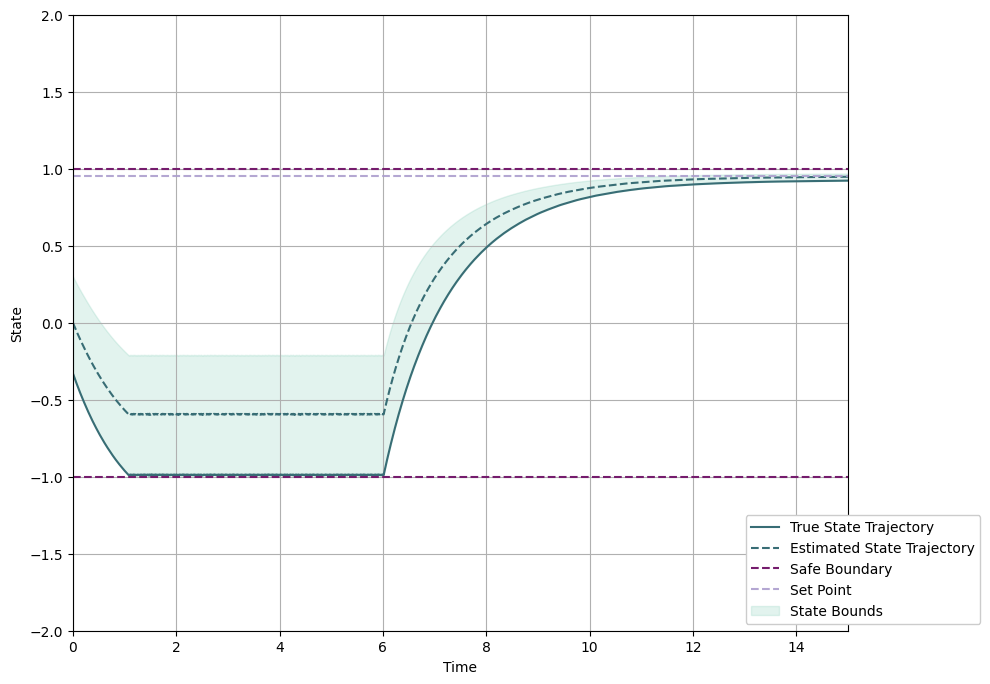

In [9]:
import matplotlib.patches as patches

rgb_colors = np.array(pypalettes.load_cmap("Alexandrite").rgb)/255.0
rgb_colors[2] = rgb_colors[2] * 0.8
black = list(rgb_colors[0])
pink = list(rgb_colors[1])
dark_teal = list(rgb_colors[2])
light_teal = list(rgb_colors[3])
purple = list(rgb_colors[4])
orange = list(rgb_colors[5])
light_purple = list(rgb_colors[6])
teal = list(rgb_colors[7])

# state_history_hjnnv = jnp.stack(state_history_hjnnv)

t_samples = np.linspace(0, num_steps * dynamics.dt, num_steps)



plt.figure(figsize=(10, 8))
plt.plot(t_samples, state_history_hjnnv, label="True State Trajectory", c=dark_teal)
plt.plot(t_samples, state_hat_history_hjnnv, label="Estimated State Trajectory", c=dark_teal, linestyle='--')
plt.plot(jnp.array([0, 15]), jnp.array([1, 1]), label="Safe Boundary", c=purple, linestyle='--', alpha=1.0)
plt.plot(jnp.array([0, 15]), jnp.array([0.95, 0.95]), label="Set Point", c=light_purple, linestyle='--', alpha=0.9)
plt.plot(jnp.array([0, 15]), jnp.array([-1, -1]), c=purple, linestyle='--', alpha=1.0)

highs = jnp.array([bounds.hi for bounds in state_bounds_history_hjnnv])
lows = jnp.array([bounds.lo for bounds in state_bounds_history_hjnnv])
plt.fill_between(t_samples, lows[:, 0], highs[:, 0], color=teal, alpha=0.2, label="State Bounds")

dyn_highs = jnp.array([bounds.hi for bounds in dynamics_state_bounds_history_hjnnv])
dyn_lows = jnp.array([bounds.lo for bounds in dynamics_state_bounds_history_hjnnv])
# plt.fill_between(t_samples, dyn_lows[:, 0], dyn_highs[:, 0], color=orange, alpha=0.2, label="Dynamics State Bounds")


# plt.gca().add_patch(patches.Rectangle((0, 0), 10, 10, linestyle='-.', linewidth=1.5, edgecolor=light_purple, facecolor='none', label="Safe Boundary"))

# for i in range(len(state_bounds_history)):
#     bounds = state_bounds_history[i]
#     lo = bounds.lo
#     hi = bounds.hi
#     if i == len(state_bounds_history) - 1:
#         rect = plt.Rectangle(
#             (lo[0], lo[1]),
#             hi[0] - lo[0],
#             hi[1] - lo[1],
#             linewidth=1,
#             edgecolor=teal + [0.75],
#             facecolor=teal + [0.25],
#             label="State Bounds",
#             zorder=0
#         )
#     else:
#         rect = plt.Rectangle(
#             (lo[0], lo[1]),
#             hi[0] - lo[0],
#             hi[1] - lo[1],
#             linewidth=1.1,
#             edgecolor=teal + [0.4],
#             facecolor=teal + [0.02],
#             zorder=0
#         )
#     plt.gca().add_patch(rect)
plt.xlabel("Time")
plt.ylabel("State")
# plt.title("Trajectory: {} Filtering with Noisy Estimates".format(filter_type))
plt.legend(loc="lower right", bbox_to_anchor=(1.18, 0.0), framealpha=1.0)
plt.xlim(0, 15)
plt.ylim(-2, 2)
plt.grid(True)
plt.show()

In [16]:
import cvxopt
import numpy as np
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False

# minimize (1/2) x^T P x + q^T x
# subject to Gx <= h

state = 1.3

Lfh = -2 * np.power(state, 2) * (state - 1.05) * (state + 1.05)
Lgh = -2 * state * (1 - np.power(state, 2))
alphah = 1 - np.power(state, 2)
rho = 0.2 * Lgh * (Lgh + 1)

P = matrix([[2.0]])
q = matrix([0.0])
print(Lgh)
G = matrix([[-Lgh]])
h = matrix([Lfh + alphah - rho])

sol = solvers.qp(P, q, G, h)
print(sol['x'][0])


1.7940000000000005
2.0502994309796456


In [10]:
filter_type = "r-cbf"  # "none", "hj", "hjnnv_maxval", "hjnnv_bestu"
# epsilon = 0.2
dt = 0.01
dynamics = Integrator(
    dt=dt,
    max_input=max_input,
    max_disturbance=max_disturbance,
    obs_disturbance=obs_disturbance,
    model_name=None
)

state_history_cbf = []
state_hat_history_cbf = []
state_bounds_history_cbf = []

key = jax.random.PRNGKey(seed)
num_steps = 1500
dynamics.set_random_seed(seed)

state_hat_0 = jnp.array([0.0])
obs = dynamics.get_observation(state_hat_0, time=0)
state_hat = estimation_function(obs)
state_bounds = hjnnv_filter.nnv_state_bounds(
    obs=obs,
    eps=epsilon
)
state = jnp.array(state_bounds.lo)
u = integrator_controller(state_hat)
ref = -0.95

for step in range(num_steps):
    key, subkey = jax.random.split(key)
    t = step * dynamics.dt
    # Simulate the system dynamics
    if step > 600:
        ref = 0.95
    obs = dynamics.get_observation(state, time=step) + epsilon
    state_hat = estimation_function(obs)
    u_nominal = integrator_controller(state_hat, ref)
    state_bounds = hjnnv_filter.nnv_state_bounds(
        obs=obs,
        eps=epsilon
    )
    # state_bounds = hj.sets.Box(state_hat - epsilon, state_hat + epsilon)
    

    time_start = time.time()

    # if step > 500:
    #     delta = -0.4
    state_hat_ = state_hat[0]
    Lfh = 0.0
    Lgh = -2 * state_hat_
    alphah = 1 - np.power(state_hat_, 2)
    # rho = 1.5 * np.abs(Lgh) * (np.abs(Lgh) + 1)
    rho = 0.25 * np.abs(Lgh) * (np.abs(Lgh) + 1)

    P = matrix([[2.0]])
    q = matrix([-float(2.0 * u_nominal[0])])
    G = matrix([[-float(Lgh)]])
    h = matrix([float(Lfh + alphah - rho)])

    sol = solvers.qp(P, q, G, h)
    u = np.array([sol['x'][0]])

    
    time_end = time.time()
    print(f"Step {step}: Filter execution time: {time_end - time_start:.5f} seconds")

    state_history_cbf.append(state)
    state_hat_history_cbf.append(state_hat)
    state_bounds_history_cbf.append(state_bounds)

    state = dynamics.step(state, u, dynamics.get_random_disturbance(), time=step)

Step 0: Filter execution time: 0.19595 seconds
Step 1: Filter execution time: 0.00440 seconds
Step 2: Filter execution time: 0.00337 seconds
Step 3: Filter execution time: 0.00212 seconds
Step 4: Filter execution time: 0.00160 seconds
Step 5: Filter execution time: 0.00150 seconds
Step 6: Filter execution time: 0.00126 seconds
Step 7: Filter execution time: 0.00109 seconds
Step 8: Filter execution time: 0.00108 seconds
Step 9: Filter execution time: 0.00106 seconds
Step 10: Filter execution time: 0.00095 seconds
Step 11: Filter execution time: 0.00116 seconds
Step 12: Filter execution time: 0.00086 seconds
Step 13: Filter execution time: 0.00075 seconds
Step 14: Filter execution time: 0.00075 seconds
Step 15: Filter execution time: 0.00075 seconds
Step 16: Filter execution time: 0.00072 seconds
Step 17: Filter execution time: 0.00080 seconds
Step 18: Filter execution time: 0.00073 seconds
Step 19: Filter execution time: 0.00073 seconds
Step 20: Filter execution time: 0.00081 seconds
St

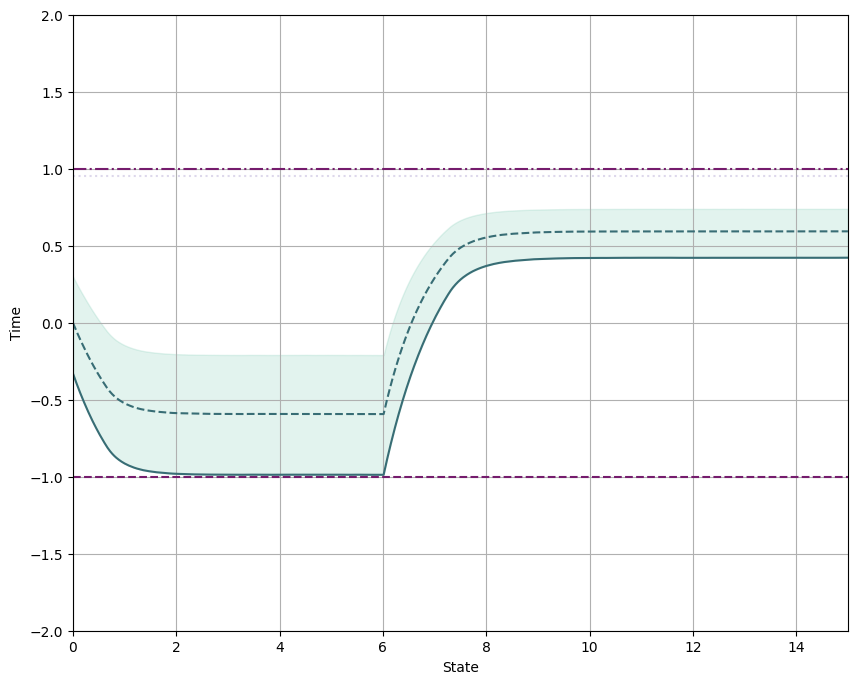

In [11]:
import matplotlib.patches as patches

rgb_colors = np.array(pypalettes.load_cmap("Alexandrite").rgb)/255.0
rgb_colors[2] = rgb_colors[2] * 0.8
black = list(rgb_colors[0])
pink = list(rgb_colors[1])
dark_teal = list(rgb_colors[2])
light_teal = list(rgb_colors[3])
purple = list(rgb_colors[4])
orange = list(rgb_colors[5])
light_purple = list(rgb_colors[6])
teal = list(rgb_colors[7])

# state_history = jnp.stack(state_history)

t_samples = np.linspace(0, num_steps * dynamics.dt, num_steps)



plt.figure(figsize=(10, 8))
plt.plot(t_samples, state_history_cbf, label="True State Trajectory", c=dark_teal)
plt.plot(t_samples, state_hat_history_cbf, label="Estimated State Trajectory", c=dark_teal, linestyle='--')
plt.plot(jnp.array([0, 15]), jnp.array([1, 1]), label="Safe Boundary", c=purple, linestyle='-.', alpha=1.0)
plt.plot(jnp.array([0, 15]), jnp.array([-1, -1]), label="Safe Boundary", c=purple, linestyle='--', alpha=1.0)
plt.plot(jnp.array([0, 15]), jnp.array([0.95, 0.95]), label="Set Point", c=light_purple, linestyle=':', alpha=0.4)

highs = jnp.array([bounds.hi for bounds in state_bounds_history_cbf])
lows = jnp.array([bounds.lo for bounds in state_bounds_history_cbf])
plt.fill_between(t_samples, lows[:, 0], highs[:, 0], color=teal, alpha=0.2, label="State Bounds")


# plt.gca().add_patch(patches.Rectangle((0, 0), 10, 10, linestyle='-.', linewidth=1.5, edgecolor=light_purple, facecolor='none', label="Safe Boundary"))

# for i in range(len(state_bounds_history)):
#     bounds = state_bounds_history[i]
#     lo = bounds.lo
#     hi = bounds.hi
#     if i == len(state_bounds_history) - 1:
#         rect = plt.Rectangle(
#             (lo[0], lo[1]),
#             hi[0] - lo[0],
#             hi[1] - lo[1],
#             linewidth=1,
#             edgecolor=teal + [0.75],
#             facecolor=teal + [0.25],
#             label="State Bounds",
#             zorder=0
#         )
#     else:
#         rect = plt.Rectangle(
#             (lo[0], lo[1]),
#             hi[0] - lo[0],
#             hi[1] - lo[1],
#             linewidth=1.1,
#             edgecolor=teal + [0.4],
#             facecolor=teal + [0.02],
#             zorder=0
#         )
#     plt.gca().add_patch(rect)
plt.xlabel("State")
plt.ylabel("Time")
# plt.title("Trajectory: {} Filtering with Noisy Estimates".format(filter_type))
# plt.legend(loc="lower right", bbox_to_anchor=(1.18, 0.0), framealpha=1.0)
plt.xlim(0, 15)
plt.ylim(-2, 2)
plt.grid(True)
plt.show()

In [12]:
filter_type = "mr-cbf"  # "none", "hj", "hjnnv_maxval", "hjnnv_bestu"
# epsilon = 0.2
dt = 0.01
dynamics = Integrator(
    dt=dt,
    max_input=max_input,
    max_disturbance=max_disturbance,
    obs_disturbance=obs_disturbance,
    model_name=None
)

state_history_mrcbf = []
state_hat_history_mrcbf = []
state_bounds_history_mrcbf = []

key = jax.random.PRNGKey(seed)
num_steps = 1500
dynamics.set_random_seed(seed)

obs = dynamics.get_observation(jnp.array([0.0]), time=0)
state_hat = estimation_function(obs)
state_bounds = hjnnv_filter.nnv_state_bounds(
    obs=obs,
    eps=epsilon
)
state = jnp.array(state_bounds.lo)
u = integrator_controller(state_hat)
ref = -0.95

for step in range(num_steps):
    key, subkey = jax.random.split(key)
    t = step * dynamics.dt
    # Simulate the system dynamics
    if step > 600:
        ref = 0.95
    obs = dynamics.get_observation(state, time=step) + epsilon
    state_hat = estimation_function(obs)
    u_nominal = integrator_controller(state_hat, ref)
    state_bounds = hjnnv_filter.nnv_state_bounds(
        obs=obs,
        eps=epsilon
    )
    ey = (state_bounds.hi - state_bounds.lo)/2.0
    

    time_start = time.time()

    # if step > 500:
    #     delta = -0.4
    state_hat_ = state_hat[0]
    u_opt = cp.Variable((1,))
    objective = cp.Minimize(cp.quad_form(u_opt - u_nominal[0], 0.5 * np.eye(1)))
    Lfh = 0.0
    Lgh = -2 * state_hat_
    alphah = 1 - np.power(state_hat_, 2)
    
    # Lipschitz constants
    L_Lfh = 0.0
    L_Lgh = 2.0
    L_alphaoh = 2.0

    constraints = [
        Lfh + Lgh * u_opt[0] + alphah - ey * (L_Lfh + L_alphaoh) - ey * L_Lgh * cp.abs(u_opt[0]) >= 0
    ]
    prob = cp.Problem(objective, constraints)
    try:
        prob.solve(warm_start=True)
        u = u_opt.value
    except:
        print(f"Step {step}: CBF QP failed to solve, using nominal control.")
        u = u_nominal
        pass
    
    if u is None:
        u = u_nominal


    # Lfh = 0.0
    # Lgh = -2 * state_hat_
    # alphah = 1 - np.power(state_hat_, 2)
    # rho = 0.25 * np.abs(Lgh) * (np.abs(Lgh) + 1)

    # P = matrix([[2.0]])
    # q = matrix([-float(2.0 * u_nominal[0])])
    # G = matrix([[-float(Lgh)]])
    # h = matrix([float(Lfh + alphah - rho)])

    # sol = solvers.qp(P, q, G, h)
    # u = np.array([sol['x'][0]])

    
    time_end = time.time()
    print(f"Step {step}: Filter execution time: {time_end - time_start:.5f} seconds")

    state_history_mrcbf.append(state)
    state_hat_history_mrcbf.append(state_hat)
    state_bounds_history_mrcbf.append(state_bounds)

    state = dynamics.step(state, u, dynamics.get_random_disturbance(), time=step)

Step 0: Filter execution time: 0.25085 seconds
Step 1: Filter execution time: 0.01452 seconds
Step 2: Filter execution time: 0.00935 seconds
Step 3: Filter execution time: 0.00738 seconds
Step 4: Filter execution time: 0.00695 seconds
Step 5: Filter execution time: 0.00711 seconds
Step 6: Filter execution time: 0.00708 seconds
Step 7: Filter execution time: 0.00706 seconds
Step 8: Filter execution time: 0.00749 seconds
Step 9: Filter execution time: 0.00704 seconds
Step 10: Filter execution time: 0.00749 seconds
Step 11: Filter execution time: 0.00776 seconds
Step 12: Filter execution time: 0.00782 seconds
Step 13: Filter execution time: 0.00726 seconds
Step 14: Filter execution time: 0.00770 seconds
Step 15: Filter execution time: 0.00691 seconds
Step 16: Filter execution time: 0.00755 seconds
Step 17: Filter execution time: 0.00706 seconds
Step 18: Filter execution time: 0.00761 seconds
Step 19: Filter execution time: 0.00690 seconds
Step 20: Filter execution time: 0.00754 seconds
St

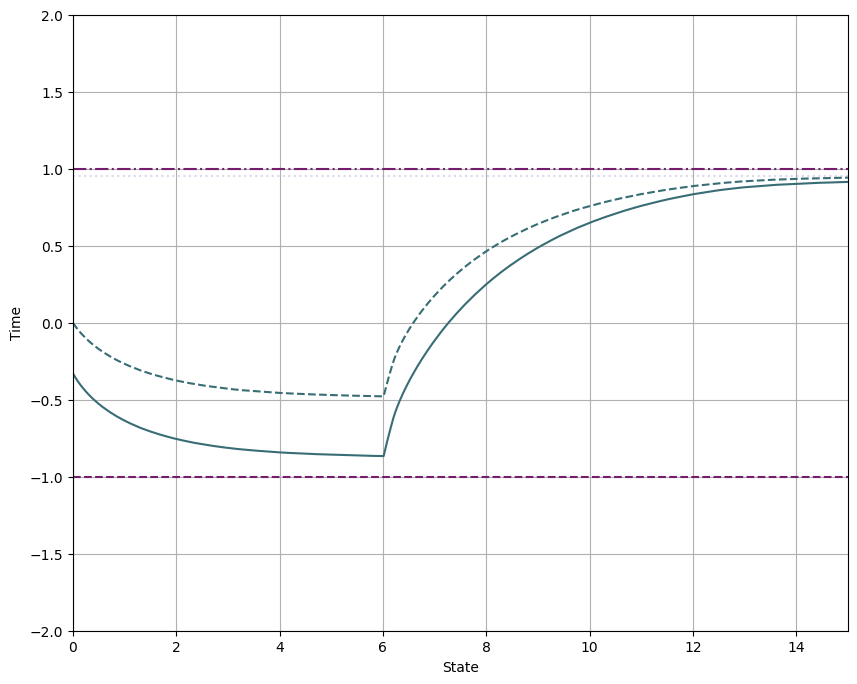

In [13]:
t_samples = np.linspace(0, num_steps * dynamics.dt, num_steps)
plt.figure(figsize=(10, 8))
plt.plot(t_samples, state_history_mrcbf, label="True State Trajectory", c=dark_teal)
plt.plot(t_samples, state_hat_history_mrcbf, label="Estimated State Trajectory", c=dark_teal, linestyle='--')
plt.plot(jnp.array([0, 50]), jnp.array([1, 1]), label="Safe Boundary", c=purple, linestyle='-.', alpha=1.0)
plt.plot(jnp.array([0, 50]), jnp.array([-1, -1]), label="Safe Boundary", c=purple, linestyle='--', alpha=1.0)
plt.plot(jnp.array([0, 50]), jnp.array([0.95, 0.95]), label="Set Point", c=light_purple, linestyle=':', alpha=0.4)

highs = jnp.array([bounds.hi for bounds in state_bounds_history_cbf])
lows = jnp.array([bounds.lo for bounds in state_bounds_history_cbf])
# plt.fill_between(t_samples, lows[:, 0], highs[:, 0], color=teal, alpha=0.2, label="State Bounds")


# plt.gca().add_patch(patches.Rectangle((0, 0), 10, 10, linestyle='-.', linewidth=1.5, edgecolor=light_purple, facecolor='none', label="Safe Boundary"))

# for i in range(len(state_bounds_history)):
#     bounds = state_bounds_history[i]
#     lo = bounds.lo
#     hi = bounds.hi
#     if i == len(state_bounds_history) - 1:
#         rect = plt.Rectangle(
#             (lo[0], lo[1]),
#             hi[0] - lo[0],
#             hi[1] - lo[1],
#             linewidth=1,
#             edgecolor=teal + [0.75],
#             facecolor=teal + [0.25],
#             label="State Bounds",
#             zorder=0
#         )
#     else:
#         rect = plt.Rectangle(
#             (lo[0], lo[1]),
#             hi[0] - lo[0],
#             hi[1] - lo[1],
#             linewidth=1.1,
#             edgecolor=teal + [0.4],
#             facecolor=teal + [0.02],
#             zorder=0
#         )
#     plt.gca().add_patch(rect)
plt.xlabel("State")
plt.ylabel("Time")
# plt.title("Trajectory: {} Filtering with Noisy Estimates".format(filter_type))
# plt.legend(loc="lower right", bbox_to_anchor=(1.18, 0.0), framealpha=1.0)
plt.xlim(0, 15)
plt.ylim(-2, 2)
plt.grid(True)
plt.show()

In [14]:
filter_type = "r-cbf-qp"  # "none", "hj", "hjnnv_maxval", "hjnnv_bestu"
# epsilon = 0.1
dt = 0.01
dynamics = Integrator(
    dt=dt,
    max_input=max_input,
    max_disturbance=max_disturbance,
    obs_disturbance=obs_disturbance,
    model_name=None
)

state_history_rcbfqp = []
state_hat_history_rcbfqp = []
state_bounds_history_rcbfqp = []

key = jax.random.PRNGKey(seed)
num_steps = 1500
dynamics.set_random_seed(seed)

obs = dynamics.get_observation(jnp.array([0.0]), time=0)
state_hat = estimation_function(obs)
state_bounds = hjnnv_filter.nnv_state_bounds(
    obs=obs,
    eps=epsilon
)
state = jnp.array(state_bounds.lo)
u = integrator_controller(state_hat)
ref = -0.95

for step in range(num_steps):
    key, subkey = jax.random.split(key)
    t = step * dynamics.dt
    # Simulate the system dynamics
    if step > 600:
        ref = 0.95
    obs = dynamics.get_observation(state, time=step) + epsilon
    state_hat = estimation_function(obs)
    u_nominal = integrator_controller(state_hat, ref)
    state_bounds = hjnnv_filter.nnv_state_bounds(
        obs=obs,
        eps=epsilon
    )
    ey = (state_bounds.hi - state_bounds.lo)/2.0
    

    time_start = time.time()

    # if step > 500:
    #     delta = -0.4
    state_hat_ = state_hat[0]
    u_opt = cp.Variable((1,))
    objective = cp.Minimize(cp.quad_form(u_opt - u_nominal[0], 0.5 * np.eye(1)))
    Lfh = 0.0
    Lgh = -2 * state_hat_
    alphah = 1 - np.power(state_hat_, 2)
    
    # Lipschitz constants
    L_Lfh = 0.0
    L_Lgh = 2.0
    L_alphaoh = 2.0

    constraints = [
        Lfh + Lgh * u_opt[0] + alphah - ey * abs(Lgh) - 0.0001**2 * Lgh**2 >= 0
    ]
    prob = cp.Problem(objective, constraints)
    try:
        prob.solve(warm_start=True)
        u = u_opt.value
    except:
        print(f"Step {step}: CBF QP failed to solve, using nominal control.")
        u = u_nominal
        pass
    
    if u is None:
        u = u_nominal


    # Lfh = 0.0
    # Lgh = -2 * state_hat_
    # alphah = 1 - np.power(state_hat_, 2)
    # rho = 0.25 * np.abs(Lgh) * (np.abs(Lgh) + 1)

    # P = matrix([[2.0]])
    # q = matrix([-float(2.0 * u_nominal[0])])
    # G = matrix([[-float(Lgh)]])
    # h = matrix([float(Lfh + alphah - rho)])

    # sol = solvers.qp(P, q, G, h)
    # u = np.array([sol['x'][0]])

    
    time_end = time.time()
    print(f"Step {step}: Filter execution time: {time_end - time_start:.5f} seconds")

    state_history_rcbfqp.append(state)
    state_hat_history_rcbfqp.append(state_hat)
    state_bounds_history_rcbfqp.append(state_bounds)

    state = dynamics.step(state, u, dynamics.get_random_disturbance(), time=step)

Step 0: Filter execution time: 0.04912 seconds
Step 1: Filter execution time: 0.00824 seconds
Step 2: Filter execution time: 0.00680 seconds
Step 3: Filter execution time: 0.00994 seconds
Step 4: Filter execution time: 0.01135 seconds
Step 5: Filter execution time: 0.01092 seconds
Step 6: Filter execution time: 0.01473 seconds
Step 7: Filter execution time: 0.00915 seconds
Step 8: Filter execution time: 0.01084 seconds
Step 9: Filter execution time: 0.00685 seconds
Step 10: Filter execution time: 0.00672 seconds
Step 11: Filter execution time: 0.00610 seconds
Step 12: Filter execution time: 0.00823 seconds
Step 13: Filter execution time: 0.00683 seconds
Step 14: Filter execution time: 0.00662 seconds
Step 15: Filter execution time: 0.00614 seconds
Step 16: Filter execution time: 0.00624 seconds
Step 17: Filter execution time: 0.00618 seconds
Step 18: Filter execution time: 0.00611 seconds
Step 19: Filter execution time: 0.00621 seconds
Step 20: Filter execution time: 0.00658 seconds
St

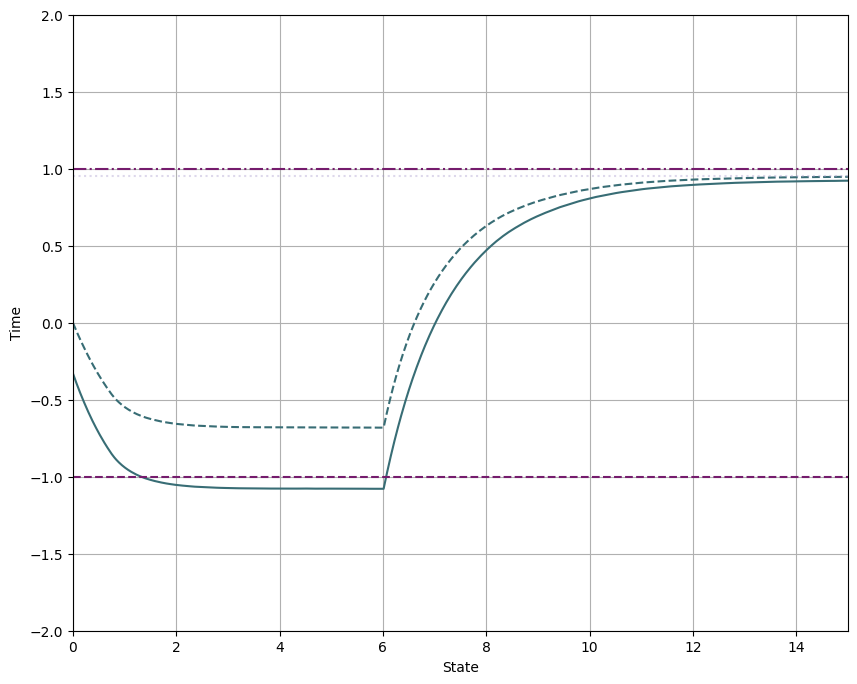

In [15]:
t_samples = np.linspace(0, num_steps * dynamics.dt, num_steps)
plt.figure(figsize=(10, 8))
plt.plot(t_samples, state_history_rcbfqp, label="True State Trajectory", c=dark_teal)
plt.plot(t_samples, state_hat_history_rcbfqp, label="Estimated State Trajectory", c=dark_teal, linestyle='--')
plt.plot(jnp.array([0, 50]), jnp.array([1, 1]), label="Safe Boundary", c=purple, linestyle='-.', alpha=1.0)
plt.plot(jnp.array([0, 50]), jnp.array([-1, -1]), label="Safe Boundary", c=purple, linestyle='--', alpha=1.0)
plt.plot(jnp.array([0, 50]), jnp.array([0.95, 0.95]), label="Set Point", c=light_purple, linestyle=':', alpha=0.4)

highs = jnp.array([bounds.hi for bounds in state_bounds_history_cbf])
lows = jnp.array([bounds.lo for bounds in state_bounds_history_cbf])
# plt.fill_between(t_samples, lows[:, 0], highs[:, 0], color=teal, alpha=0.2, label="State Bounds")


# plt.gca().add_patch(patches.Rectangle((0, 0), 10, 10, linestyle='-.', linewidth=1.5, edgecolor=light_purple, facecolor='none', label="Safe Boundary"))

# for i in range(len(state_bounds_history)):
#     bounds = state_bounds_history[i]
#     lo = bounds.lo
#     hi = bounds.hi
#     if i == len(state_bounds_history) - 1:
#         rect = plt.Rectangle(
#             (lo[0], lo[1]),
#             hi[0] - lo[0],
#             hi[1] - lo[1],
#             linewidth=1,
#             edgecolor=teal + [0.75],
#             facecolor=teal + [0.25],
#             label="State Bounds",
#             zorder=0
#         )
#     else:
#         rect = plt.Rectangle(
#             (lo[0], lo[1]),
#             hi[0] - lo[0],
#             hi[1] - lo[1],
#             linewidth=1.1,
#             edgecolor=teal + [0.4],
#             facecolor=teal + [0.02],
#             zorder=0
#         )
#     plt.gca().add_patch(rect)
plt.xlabel("State")
plt.ylabel("Time")
# plt.title("Trajectory: {} Filtering with Noisy Estimates".format(filter_type))
# plt.legend(loc="lower right", bbox_to_anchor=(1.18, 0.0), framealpha=1.0)
plt.xlim(0, 15)
plt.ylim(-2, 2)
plt.grid(True)
plt.show()

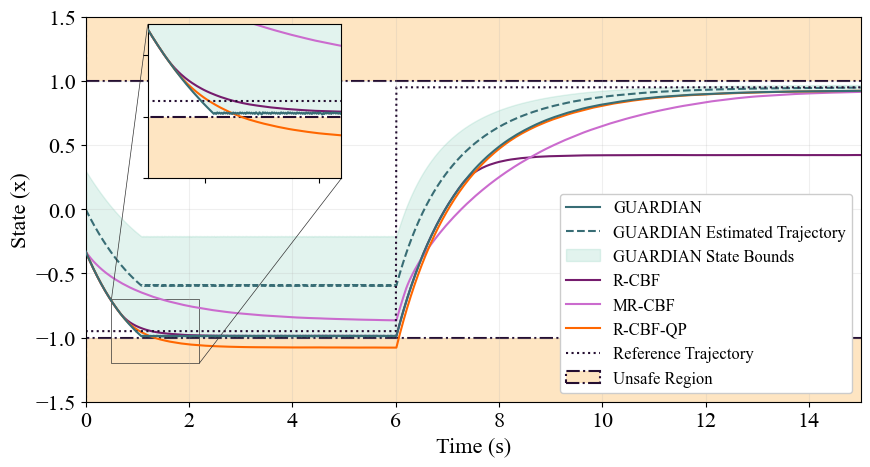

In [16]:
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

plt.rcParams['font.family'] = 'serif'          # e.g., 'sans-serif', 'serif', 'monospace'
plt.rcParams['font.serif'] = ['Times New Roman']  # specify font
plt.rcParams['font.size'] = 16

if epsilon == 0.1:
    magnify_inset = True
else:
    magnify_inset = False

rgb_colors = np.array(pypalettes.load_cmap("Alexandrite").rgb)/255.0
rgb_colors[2] = rgb_colors[2] * 0.8
black = list(rgb_colors[0])
pink = list(rgb_colors[1])
dark_teal = list(rgb_colors[2])
light_teal = list(rgb_colors[3])
purple = list(rgb_colors[4])
orange = list(rgb_colors[5])
yellow = [240/255.0, 225/255.0, 0/255.0]  # yellow
dark_orange = [255/255.0, 103/255.0, 0/255.0]
# gray = [70/255.0, 45/255.0, 255/255.0]  # red
# gray = dark_orange
light_purple = list(rgb_colors[6])
teal = list(rgb_colors[7])
hot_pink = [1.0, 46/255.0, 204/255.0]  # hot pink
# state_history = jnp.stack(state_history)

trajectory_linewidth = 1.5
ref_linewidth = 1.5
boundary_linewidth = 1.5
unsafe_region_alpha = 0.4

t_samples = np.linspace(0, num_steps * dynamics.dt, num_steps)



fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t_samples, state_history_hjnnv, label="GUARDIAN", c=dark_teal, linewidth=trajectory_linewidth, zorder=10)
ax.plot(t_samples, state_hat_history_hjnnv, label="GUARDIAN Estimated Trajectory", c=dark_teal, linestyle='--', linewidth=trajectory_linewidth)
highs = jnp.array([bounds.hi for bounds in state_bounds_history_hjnnv])
lows = jnp.array([bounds.lo for bounds in state_bounds_history_hjnnv])
ax.fill_between(t_samples, lows[:, 0], highs[:, 0], color=teal, alpha=0.2, label="GUARDIAN State Bounds")

ax.plot(t_samples, state_history_cbf, label="R-CBF", c=purple, linewidth=trajectory_linewidth)
# ax.plot(t_samples, state_hat_history_cbf, label="Estimated State Trajectory", c=purple, linestyle='--')

# highs = jnp.array([bounds.hi for bounds in state_bounds_history_cbf])
# lows = jnp.array([bounds.lo for bounds in state_bounds_history_cbf])

ax.plot(t_samples, state_history_mrcbf, label="MR-CBF", c=pink, linewidth=trajectory_linewidth)
ax.plot(t_samples, state_history_rcbfqp, label="R-CBF-QP", c=dark_orange, linewidth=trajectory_linewidth)

ax.plot(t_samples, ref_history_hjnnv, label="Reference Trajectory", c=black, linestyle=':', alpha=1.0, linewidth=ref_linewidth)

# plt.plot(jnp.array([0, 15]), jnp.array([1, 1]), label="Safe Boundary", c=black, linestyle='-.', alpha=1.0)
# plt.plot(jnp.array([0, 15]), jnp.array([-1, -1]), c=black, linestyle='-.', alpha=1.0)
# plt.plot(t_samples, state_hat_history_mrcbf, label="Estimated State Trajectory", c=pink, linestyle='--')
# plt.fill_between(t_samples, lows[:, 0], highs[:, 0], color=pink, alpha=0.2, label="State Bounds")


ax.add_patch(patches.Rectangle((0, 1), 20, 2, linestyle='-.', linewidth=boundary_linewidth, edgecolor=black, facecolor=orange + [unsafe_region_alpha], label="Unsafe Region"))
ax.add_patch(patches.Rectangle((0, -3), 20, 2, linestyle='-.', linewidth=boundary_linewidth, edgecolor=black, facecolor=orange + [unsafe_region_alpha]))

if epsilon == 0.1:
    x1, x2, y1, y2 = 0.5, 2.2, -1.2, -0.7  # subregion of the original image
    axins = ax.inset_axes(
        [0.08, 0.58, 0.25, 0.4],
        xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
    mark_inset(ax, axins, loc1=4, loc2=2, fc="none", ec="0.2", lw=0.5)
    axins.plot(t_samples, state_history_hjnnv, c=dark_teal, linewidth=trajectory_linewidth, zorder=10)
    axins.plot(t_samples, state_hat_history_hjnnv, c=dark_teal, linestyle='--', linewidth=trajectory_linewidth)
    axins.fill_between(t_samples, lows[:, 0], highs[:, 0], color=teal, alpha=0.2)
    axins.plot(t_samples, state_history_cbf, c=purple, linewidth=trajectory_linewidth)
    axins.plot(t_samples, state_history_mrcbf, c=pink, linewidth=trajectory_linewidth)
    axins.plot(t_samples, state_history_rcbfqp, c=dark_orange, linewidth=trajectory_linewidth)
    axins.plot(t_samples, ref_history_hjnnv, c=black, linestyle=':', alpha=1.0, linewidth=ref_linewidth)
    axins.add_patch(patches.Rectangle((0, -3), 20, 2, linestyle='-.', linewidth=boundary_linewidth, edgecolor=black, facecolor=orange + [unsafe_region_alpha]))
elif epsilon == 0.2:
    x1, x2, y1, y2 = 0.1, 1.8, -1.35, -0.85  # subregion of the original image
    axins = ax.inset_axes(
        [0.6, 0.08, 0.35, 0.4],
        xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
    mark_inset(ax, axins, loc1=3, loc2=2, fc="none", ec="0.2", lw=0.5)
    axins.plot(t_samples, state_history_hjnnv, c=dark_teal, linewidth=trajectory_linewidth, zorder=10)
    axins.plot(t_samples, state_hat_history_hjnnv, c=dark_teal, linestyle='--', linewidth=trajectory_linewidth)
    axins.fill_between(t_samples, lows[:, 0], highs[:, 0], color=teal, alpha=0.2)
    axins.plot(t_samples, state_history_cbf, c=purple, linewidth=trajectory_linewidth)
    axins.plot(t_samples, state_history_mrcbf, c=pink, linewidth=trajectory_linewidth)
    axins.plot(t_samples, state_history_rcbfqp, c=dark_orange, linewidth=trajectory_linewidth)
    axins.plot(t_samples, ref_history_hjnnv, c=black, linestyle=':', alpha=1.0, linewidth=ref_linewidth)
    axins.add_patch(patches.Rectangle((0, -3), 20, 2, linestyle='-.', linewidth=boundary_linewidth, edgecolor=black, facecolor=orange + [unsafe_region_alpha]))


# axins.imshow(Z2, extent=extent, origin="lower")

# ax.indicate_inset_zoom(axins, edgecolor="black")

# for i in range(len(state_bounds_history)):
#     bounds = state_bounds_history[i]
#     lo = bounds.lo
#     hi = bounds.hi
#     if i == len(state_bounds_history) - 1:
#         rect = plt.Rectangle(
#             (lo[0], lo[1]),
#             hi[0] - lo[0],
#             hi[1] - lo[1],
#             linewidth=1,
#             edgecolor=teal + [0.75],
#             facecolor=teal + [0.25],
#             label="State Bounds",
#             zorder=0
#         )
#     else:
#         rect = plt.Rectangle(
#             (lo[0], lo[1]),
#             hi[0] - lo[0],
#             hi[1] - lo[1],
#             linewidth=1.1,
#             edgecolor=teal + [0.4],
#             facecolor=teal + [0.02],
#             zorder=0
#         )
#     plt.gca().add_patch(rect)
ax.set_xlabel("Time (s)")
ax.set_ylabel("State (x)")
# plt.title("Trajectory: {} Filtering with Noisy Estimates".format(filter_type))
if epsilon == 0.1:
    plt.legend(loc="lower right", framealpha=1.0, fontsize=12)
    yliml = -1.5
else:
    yliml = -2.0
ax.set_xlim(0, 15)
ax.set_ylim(yliml, 1.5)
ax.grid(True, alpha=0.2)
plt.show()

In [502]:
def simulate_filter(filter_type, epsilon, num_steps=1000):
    dt = 0.01
    max_input = 10.0
    max_disturbance = 1e-12
    obs_disturbance = 1e-12
    seed = 0
    dynamics = CBF_Comparison(
        dt=dt,
        max_input=max_input,
        max_disturbance=max_disturbance,
        obs_disturbance=obs_disturbance,
        model_name=None
    )
    if filter_type in ["hjnnv_bestu", "hjnnv_maxval", "hj"]:
        grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(
                    hj.sets.Box(
                        np.array([-6.]),
                        np.array([6.])),
                    (50,),
                )
        values = -jnp.power(grid.states[..., 0], 2) + 1

        solver_settings = hj.SolverSettings.with_accuracy("very_high",
                                                        hamiltonian_postprocessor=hj.solver.backwards_reachable_tube)
        cmap = 'viridis'

        def estimation_function(observation):
            return observation

        hjnnv_filter = hjnnvUncertaintyAwareFilter(
            dynamics=dynamics,
            pred_model=estimation_function,
            grid=grid,
            initial_values=values,
            num_controls=50,
            num_disturbances=3,
            time_horizon=10.0
        )

    eps_multiplier = 1.0

    state_history = []
    state_hat_history = []
    state_bounds_history = []

    key = jax.random.PRNGKey(seed)
    num_steps = 1000
    dynamics.set_random_seed(seed)

    state = jnp.array([1.3])
    # state_hat = state + jax.random.uniform(key, minval=-epsilon, maxval=epsilon, shape=state.shape)
    state_hat = state + epsilon * eps_multiplier
    u = cbf_controller(state)
    zero_counter = 0

    for step in range(num_steps):
        key, subkey = jax.random.split(key)
        t = step * dynamics.dt
        # Simulate the system dynamics
        obs = dynamics.get_observation(state, time=step)
        u_nominal = cbf_controller(state)
        # state_hat = state + jax.random.uniform(subkey, minval=-epsilon, maxval=epsilon, shape=state.shape)
        state_hat = state + epsilon * eps_multiplier
        
        time_start = time.time()
        if filter_type == "hjnnv_maxval" or filter_type == "hjnnv_bestu":
            state_bounds = hj.sets.Box(state_hat - epsilon, state_hat + epsilon)

            if filter_type == "hjnnv_maxval":
                v_star, u_star, worst_val, val_filter, min_vals, distances = hjnnv_filter.ua_filter_max_val(
                    u_nominal,
                    state_bounds,
                    num_states=3,
                    eps=1e-6
                )
            elif filter_type == "hjnnv_bestu":
                v_star, u_star, worst_val, val_filter, min_vals, distances, _, _, = hjnnv_filter.ua_filter_best_u(
                    u_nominal,
                    state_bounds,
                    num_states=10,
                    delta=0.01,
                )
        elif filter_type == "hj":

            lo = state - 1e-8
            hi = state + 1e-8
            state_bounds = hj.sets.Box(
                lo,
                hi
            )
            time_start = time.time()
            v_star, u_star, worst_val, val_filter, min_vals, distances = hjnnv_filter.ua_filter_max_val(
                u_nominal,
                state_bounds,
                num_states=2
            )
        elif filter_type == "r-cbf":
            state_bounds = hj.sets.Box(state_hat - epsilon, state_hat + epsilon)

            state_hat_ = state_hat[0]
            Lfh = -2 * np.power(state_hat_, 2) * (state_hat_ - 1.05) * (state_hat_ + 1.05)
            Lgh = -2 * state_hat_ * (1 - np.power(state_hat_, 2))
            alphah = 1 - np.power(state_hat_, 2)
            rho = 0.2 * Lgh * (Lgh + 1)

            P = matrix([[2.0]])
            q = matrix([0.0])
            G = matrix([[-float(Lgh)]])
            h = matrix([float(Lfh + alphah - rho)])

            sol = solvers.qp(P, q, G, h)
            u_star = np.array([sol['x'][0]])
            v_star = 0.0
            val_filter = -1.0  # negative value means filtering applied

        elif filter_type == "mr-cbf":
            state_bounds = hj.sets.Box(state_hat - epsilon, state_hat + epsilon)

            state_hat_ = state_hat[0]

            if state_hat_ < 100:
                u_opt = cp.Variable((1,))
                objective = cp.Minimize(cp.quad_form(u_opt, 0.5 * np.eye(1)))
                Lfh = -2 * np.power(state_hat_, 2) * (state_hat_ - 1.05) * (state_hat_ + 1.05)
                Lgh = -2 * state_hat_ * (1 - np.power(state_hat_, 2))
                alphah = 1 - np.power(state_hat_, 2)
                
                # Lipschitz constants
                L_Lfh = 3.59
                L_Lgh = 4
                L_alphaoh = 2

                constraints = [
                    Lfh + Lgh * u_opt[0] + alphah - epsilon * (L_Lfh + L_alphaoh) - epsilon * L_Lgh * cp.abs(u_opt[0]) >= 0
                ]
                prob = cp.Problem(objective, constraints)
                try:
                    prob.solve(warm_start=True, verbose=False)
                except:
                    pass
                # prob.solve(warm_start=True, verbose=False)
                u_star = u_opt.value
                if u_star is None:
                    u_star = u_nominal
            else:
                u_star = u_nominal

            # P = matrix([[2.0]])
            # q = matrix([0.0])
            # G = matrix([[float(epsilon * L_Lgh - Lgh)]])
            # h = matrix([float(Lfh + alphah - epsilon * (L_Lfh + L_alphaoh))])

            # sol = solvers.qp(P, q, G, h)
            
            # u_star = np.array([sol['x'][0]])
            v_star = 0.0
            val_filter = -1.0  # negative value means filtering applied

        elif filter_type == "none":
            u = u_nominal
            v_star = 0.0
            val_filter = 1.0  # positive value means no hjnnv filtering
            lo = state - 1e-8
            hi = state + 1e-8
            state_bounds = hj.sets.Box(
                lo,
                hi
            )
        # if np.linalg.norm(state-1.0) < 1e-2:
        #     print(f"Step {step}: State near equilibrium, applying nominal control.")
        #     zero_counter += 1
        #     u = u_nominal
        # elif zero_counter < 100 and zero_counter > 0:
        #     print(f"Step {step}: In zero counter phase ({zero_counter}/100), applying nominal control.")
        #     zero_counter += 1
        #     u = u_nominal
        #     if zero_counter == 100:
        #         zero_counter = 0
        # else:
        if val_filter < 0.0:
            # print(f"Step {step}: Using filtered control u_star={u_star}, state={state}, v_star={v_star}, val_filter={val_filter}")
            u = u_star
        else:
            u = u_nominal
        
        time_end = time.time()
        # print(f"Step {step}: Filter execution time: {time_end - time_start:.5f} seconds")

        state_history.append(state)
        state_hat_history.append(state_hat)
        state_bounds_history.append(state_bounds)

        state = dynamics.step(state, u, dynamics.get_random_disturbance(), time=step)

    # print(f"Filter type: {epsilon}, u_min: {u_min}, u_max: {u_max}")
    
    return state_history, state_hat_history, state_bounds_history

        

In [503]:


mrcbf_history_dict = {}
rcbf_history_dict = {}
hjnnv_history_dict = {}
eps_list = [0.0, 0.01, 0.05, 0.1, 0.2, 0.5, 0.8]
# eps_list = [0.01, 0.05]

for eps in eps_list:
    # print(f"Simulating MR-CBF filter with epsilon={eps}")
    # history = simulate_filter("mr-cbf", epsilon=eps)
    # state_history_mrcbf = history[0]
    # state_hat_history_mrcbf = history[1]
    # state_bounds_history_mrcbf = histo|ry[2]
    # mrcbf_history_dict[eps] = (state_history_mrcbf, state_hat_history_mrcbf, state_bounds_history_mrcbf)

    print(f"Simulating R-CBF filter with epsilon={eps}")
    history = simulate_filter("r-cbf", epsilon=eps)
    state_history_cbf = history[0]
    state_hat_history_cbf = history[1]
    state_bounds_history_cbf = history[2]
    rcbf_history_dict[eps] = (state_history_cbf, state_hat_history_cbf, state_bounds_history_cbf)

    print(f"Simulating HJNNV filter with epsilon={eps}")
    history = simulate_filter("hjnnv_bestu", epsilon=eps)
    state_history_hjnnv = history[0]
    state_hat_history_hjnnv = history[1]
    state_bounds_history_hjnnv = history[2]
    hjnnv_history_dict[eps] = (state_history_hjnnv, state_hat_history_hjnnv, state_bounds_history_hjnnv)

Simulating R-CBF filter with epsilon=0.0
Simulating HJNNV filter with epsilon=0.0


100%|##########| 10.0000/10.0 [00:04<00:00,  2.28sim_s/s]


Simulating R-CBF filter with epsilon=0.01
Simulating HJNNV filter with epsilon=0.01


100%|##########| 10.0000/10.0 [00:04<00:00,  2.29sim_s/s]


Simulating R-CBF filter with epsilon=0.05
Simulating HJNNV filter with epsilon=0.05


100%|##########| 10.0000/10.0 [00:04<00:00,  2.21sim_s/s]


Simulating R-CBF filter with epsilon=0.1
Simulating HJNNV filter with epsilon=0.1


100%|##########| 10.0000/10.0 [00:04<00:00,  2.27sim_s/s]


Simulating R-CBF filter with epsilon=0.2
Simulating HJNNV filter with epsilon=0.2


100%|##########| 10.0000/10.0 [00:04<00:00,  2.33sim_s/s]


Simulating R-CBF filter with epsilon=0.5
Simulating HJNNV filter with epsilon=0.5


100%|##########| 10.0000/10.0 [00:04<00:00,  2.29sim_s/s]


Simulating R-CBF filter with epsilon=0.8
Simulating HJNNV filter with epsilon=0.8


100%|##########| 10.0000/10.0 [00:04<00:00,  2.25sim_s/s]


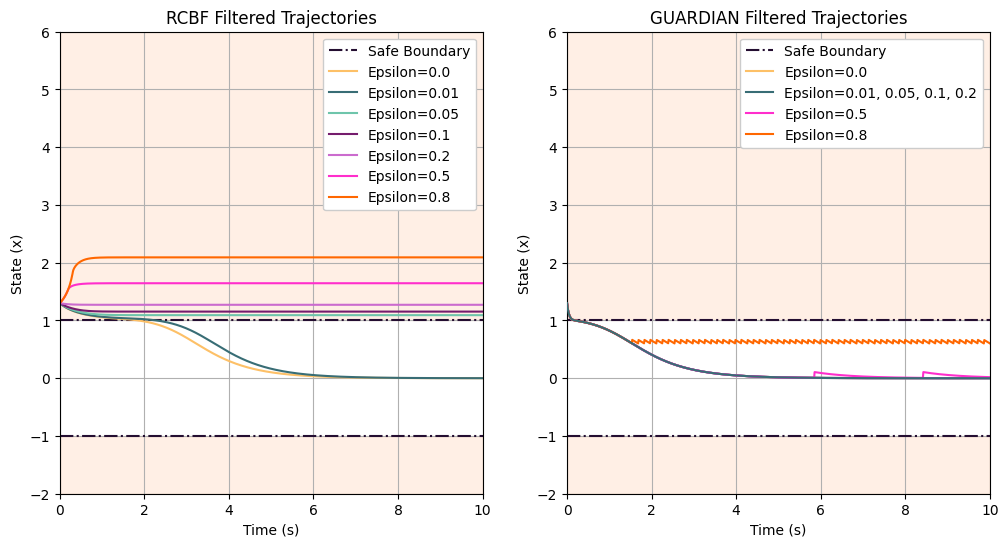

In [501]:
rgb_colors = np.array(pypalettes.load_cmap("Alexandrite").rgb)/255.0
rgb_colors[2] = rgb_colors[2] * 0.8
black = list(rgb_colors[0])
pink = list(rgb_colors[1])
dark_teal = list(rgb_colors[2])
light_teal = list(rgb_colors[3])
purple = list(rgb_colors[4])
orange = list(rgb_colors[5])
yellow = [240/255.0, 225/255.0, 0/255.0]  # yellow
dark_orange = [255/255.0, 103/255.0, 0/255.0]
# gray = [70/255.0, 45/255.0, 255/255.0]  # red
# gray = dark_orange
light_purple = list(rgb_colors[6])
teal = list(rgb_colors[7])
hot_pink = [1.0, 46/255.0, 204/255.0]  # hot pink

color_dict = {
    0.0: orange,
    0.01: dark_teal,
    0.05: teal,
    0.1: purple,
    0.2: pink,
    0.5: hot_pink,
    0.8: dark_orange,
    1.1: black
}
safe_region_color = dark_orange
rect_alpha = 0.1

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for ax in axs:
    rect_l = patches.Rectangle(
        (0, -2),
        10,
        1,
        linestyle='-',
        linewidth=1.0,
        edgecolor=safe_region_color,
        facecolor=safe_region_color,
        alpha=rect_alpha,
        zorder=0
    )
    rect_u = patches.Rectangle(
        (0, 1),
        10,
        9,
        linestyle='-',
        linewidth=1.0,
        edgecolor=safe_region_color,
        facecolor=safe_region_color,
        alpha=rect_alpha,
        zorder=0
    )
    ax.add_patch(rect_l)
    ax.add_patch(rect_u)
    ax.plot(jnp.array([0, 10]), jnp.array([1, 1]), label="Safe Boundary", c=black, linestyle='-.', alpha=1.0)
    ax.plot(jnp.array([0, 10]), jnp.array([-1, -1]), c=black, linestyle='-.', alpha=1.0)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("State (x)")
    ax.set_xlim(0, 10)
    ax.set_ylim(-2.0, 6.0)
    # ax.set_ylim(0.9, 1.05)
    ax.grid(True)

for eps in eps_list:
    state_history_rcbf, state_hat_history_rcbf, state_bounds_history_rcbf = rcbf_history_dict[eps]
    # state_history_mrcbf, state_hat_history_mrcbf, state_bounds_history_mrcbf = mrcbf_history_dict[eps]
    state_history_hjnnv, state_hat_history_hjnnv, state_bounds_history_hjnnv = hjnnv_history_dict[eps]

    t_samples = np.linspace(0, num_steps * dynamics.dt, num_steps)

    if eps==0.01:
        label_eps = f"Epsilon=0.01, 0.05, 0.1, 0.2"
        axs[1].plot(t_samples, state_history_hjnnv, c=color_dict[eps], label=label_eps, zorder=10)
    elif eps in [0.05, 0.1, 0.2]:
        axs[1].plot(t_samples, state_history_hjnnv, c=color_dict[eps])
    else:
        label_eps = f"Epsilon={eps}"
        axs[1].plot(t_samples, state_history_hjnnv, c=color_dict[eps], label=label_eps)
        
    
    # plt.plot(t_samples, state_hat_history_hjnnv, label="Estimated State Trajectory", c=dark_teal, linestyle='--')
    

    highs = jnp.array([bounds.hi for bounds in state_bounds_history_hjnnv])
    lows = jnp.array([bounds.lo for bounds in state_bounds_history_hjnnv])
    # axs[1].fill_between(t_samples, lows[:, 0], highs[:, 0], color=teal, alpha=0.2)

    axs[0].plot(t_samples, state_history_rcbf, c=color_dict[eps], label=f"Epsilon={eps}")
    # axs[0].plot(t_samples, state_history_mrcbf, c=color_dict[eps], linestyle='--', label=f"MR-CBF Epsilon={eps}")
    # axs[0].plot(t_samples, state_hat_history_rcbf, label="Estimated State Trajectory", c=purple, linestyle='--')

    highs = jnp.array([bounds.hi for bounds in state_bounds_history_rcbf])
    lows = jnp.array([bounds.lo for bounds in state_bounds_history_rcbf])
    # axs[0].fill_between(t_samples, lows[:, 0], highs[:, 0], color=pink, alpha=0.2)

axs[0].set_title("RCBF Filtered Trajectories")
axs[1].set_title("GUARDIAN Filtered Trajectories")
axs[0].legend(loc="upper right", framealpha=1.0)
axs[1].legend(loc="upper right", framealpha=1.0)



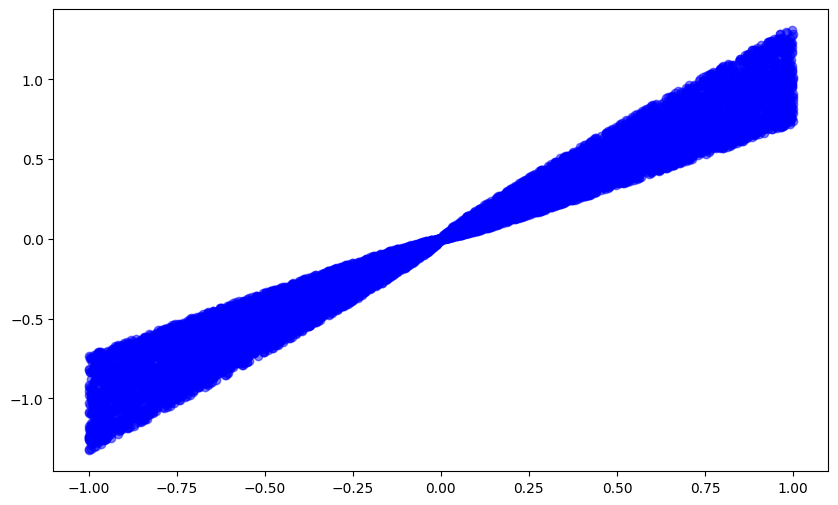

In [ ]:
def observation_function(state):
    return np.cbrt(state)

def estimation_function(observation):
    return observation * observation * observation
    

xs = jnp.linspace(-1.0, 1.0, 1000)
key = jax.random.PRNGKey(0)
num_samples = 10
xs_est_list = []
for x in xs:
    key, subkey = jax.random.split(key)
    obs = observation_function(x)
    noisy_observations = obs + jax.random.uniform(subkey, minval=-0.1, maxval=0.1, shape=(num_samples))
    xs_est = estimation_function(noisy_observations)
    xs_est_list.append(xs_est)
    # est = estimation_function(obs)
    # print(f"State: {x}, Observation: {obs}, Estimated State: {est}")
# observations = observation_function(xs)
# observations_noisy = observations + jax.random.normal(jax.random.PRNGKey(0), shape=observations.shape) * 0.05

xs_est_array = jnp.array(xs_est_list)
plt.figure(figsize=(10, 6))
for i in range(xs_est_array.shape[0]):
    plt.scatter(jnp.ones(xs_est_array.shape[1]) * xs[i], xs_est_array[i, :], color='blue', alpha=0.5)